In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_objects import Fluorophore
from imaging_model import fast_form_A, fast_form_A_from_photons
from information_matrix import read_qe, fast_form_q_vec, FIM

In [2]:
fluorophore_string_list = ["mEmerald", "mTagBFP2", "mCherry", "mNeptune2.5"]
brightness_list         = [39.1,       32.38,      15.85,     22.8         ]
wavelength_range = (400,900)

fluorophore_list = []
for fluorophore_name, fluorophore_brightness in zip(fluorophore_string_list, brightness_list):
    fluorophore_list.append(Fluorophore(fluorophore_name, fluorophore_brightness, index_range=wavelength_range))

list(map(Fluorophore.get_name, fluorophore_list))

['mEmerald', 'mTagBFP2', 'mCherry', 'mNeptune2.5']

In [3]:
illumination_wavelengths = np.array([405, 488, 561, 637])
bin_width = 10
x = [1,1,1,1]

params_wo_k = (illumination_wavelengths, wavelength_range, bin_width, fluorophore_list)

In [4]:
qe = read_qe(wavelength_range)
q_vec = fast_form_q_vec(qe, wavelength_range, bin_width, len(illumination_wavelengths))

def calc_FOM(A, x):
    F = FIM(A, x, q_vec, 2)
    FIM_inv = np.linalg.inv(F)
    CRLB = np.diagonal(FIM_inv)
    FOM_list = np.array(x) / np.sqrt(CRLB)
    
    return FOM_list

In [5]:
def FOM_from_desired_photons(desired_photons):
    A = fast_form_A_from_photons(desired_photons, *params_wo_k)
    return calc_FOM(A,x)

In [12]:
FOM_from_desired_photons(100)

array([8.65091711, 7.36483981, 3.78201977, 8.15429061])

In [7]:
fast_form_A_from_photons(1000, *params_wo_k).sum(axis=1).reshape((4,50)).sum(axis=1)

array([1000., 1000., 1000., 1000.])

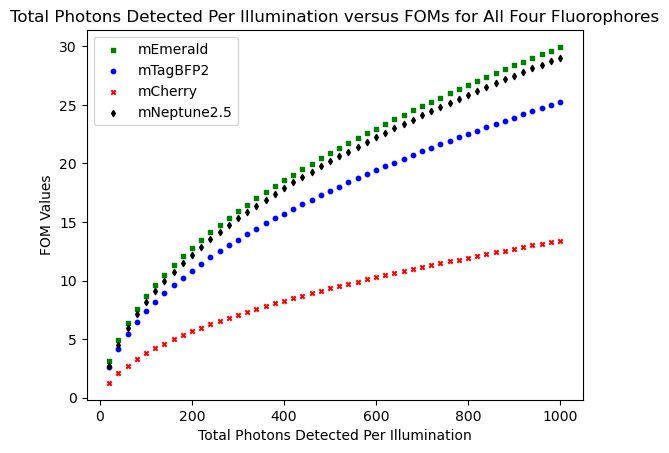

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)

X = np.arange(20,1020,20)
Y = {}
for fluorophore in fluorophore_list:
    Y[fluorophore] = []
for desired_photons in X:
    A = fast_form_A_from_photons(desired_photons, *params_wo_k)
    figures_of_merit = calc_FOM(A,x)
    for j in range(len(fluorophore_list)):
        Y[fluorophore_list[j]].append(figures_of_merit[j])


color = {
    'mEmerald'    : 'g',
    'mTagBFP2'    : 'b',
    'mCherry'     : 'r',
    'mNeptune2.5' : 'black'
}
marker = {
    'mEmerald'    : 's',
    'mTagBFP2'    : 'o',
    'mCherry'     : 'x',
    'mNeptune2.5' : 'd'
}

for fluorophore in fluorophore_list:
    ax.scatter(X, Y[fluorophore], s=10, c=color[fluorophore.name], marker=marker[fluorophore.name], label=fluorophore.name)

plt.legend(loc='upper left')
plt.ylabel('FOM Values')
plt.xlabel('Total Photons Detected Per Illumination')
plt.title('Total Photons Detected Per Illumination versus FOMs for All Four Fluorophores')
plt.show()